In [30]:
import pandas as pd
import numpy as np

df_unesco = pd.read_csv("unesco.csv")
df_unesco_train = pd.read_csv("unesco_train.csv")
df_unesco.set_index(["Country", "Year"], inplace=True)
df_unesco_train.set_index(["Country", "Year"], inplace=True)

df_unesco_train = df_unesco_train[df_unesco_train["pop14under"] > 0].copy()
df_unesco_train
df_unesco_train = df_unesco_train.dropna()
df_unesco_train.head()

fertilityRate  lifeExpectancy  mortalityRate  popGrowth  \
Country Year                                                            
Canada  2015         1.5630        81.90000            4.7    0.83277   
        2016         1.5433        82.30051            4.6    1.19865   
        2017         1.4961        82.47049            4.5    1.21548   
Benin   2015         5.0480        60.63900           66.6    2.77298   
        2016         4.9770        60.90700           65.1    2.76353   

              ruralPopPct  gdpGrowthPct         gdpUS  gdpPerCapitaUS  \
Country Year                                                            
Canada  2015       18.741       1.00088  1.552522e+12     43327.17364   
        2016       18.700       1.41410  1.526954e+12     42105.90006   
        2017       18.650       3.04735  1.647120e+12     44870.77616   
Benin   2015       54.305       2.09581  8.291156e+09       783.96308   
        2016       53.771       3.96486  8.573160e+09       788.53244   

              gdpPerCapita ppp  gdp pppInternational  ...  gniPerCapita  \
Country Year                                          ...                 
Canada  2015       44406.66587          1.591202e+12  ...       47380.0   
        2016       44819.11188          1.625347e+12  ...       43770.0   
        2017       46509.71703          1.707283e+12  ...       42790.0   
Benin   2015        2122.23540          2.244466e+10  ...         860.0   
        2016        2169.70967          2.358973e+10  ...         820.0   

              gniPerCapita ppp  pop14under  pop15to24  pop25to64  pop65over  \
Country Year                                                                  
Canada  2015           43720.0    5761.199   4648.731  19833.155   5783.591   
        2016           44280.0    5784.173   4620.449  19991.505   5986.817   
        2017           46010.0    5829.397   4562.767  20153.331   6186.600   
Benin   2015            2110.0    4551.582   2098.709   3584.299    341.362   
        2016            2160.0    4660.437   2157.572   3702.286    351.768   

              hivPct  povertyRatio   totalPop  happinessScore  
Country Year                                                   
Canada  2015     0.0           0.0  36026.676           7.427  
        2016     0.0           0.0  36382.944           7.404  
        2017     0.0           0.0  36732.095           7.316  
Benin   2015     1.0          49.5  10575.952           3.340  
        2016     1.0           0.0  10872.063           3.484  

[5 rows x 21 columns]

The first step is to find the type of machine learning regressor that works the best on our data.  I test this by comparing RMSE's of different learners, including all the features.

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# my_cols = ['fertilityRate', 'lifeExpectancy', 'popGrowth',
#            'ruralPopPct', 'mortalityRate', 'gdpGrowthPct', 
#            'gdpUS', 'gdpPerCapita ppp', 'gdp pppInternational',
#            'gni', 'gniPerCapita', 'happinessScore']

Xtrain = df_unesco_train.drop("happinessScore", axis=1)
ytrain = df_unesco_train["happinessScore"]

def tryModel(model):

    pipeline = make_pipeline(
      StandardScaler(),
      model
    )

    cv_errs = -cross_val_score(pipeline, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=10)
  
    return pipeline, np.sqrt(cv_errs.mean())

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt")
params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
gr = GradientBoostingRegressor(**params) 

model_dict = {'lr': lr, 'knn': knn, 'dt': dt, 'rf': rf, 'gr': gr}

errs = pd.Series()
for k, v in model_dict.items():
  errs[k] = tryModel(v)[1]
errs

lr     0.857040
knn    0.633230
dt     0.807410
rf     0.567622
gr     0.626182
dtype: float64

With the lowest estimated test RMSE around .6, random forrest is the best machine learning model out of those I tested.  The RMSE of .6 can be interpreted as follows: given a country and a year, a prediction for the happiness score will be off by .6 on average.

The cells below is where I perform feature selection, choosing only the features that help to predict happines scores.  

20
20


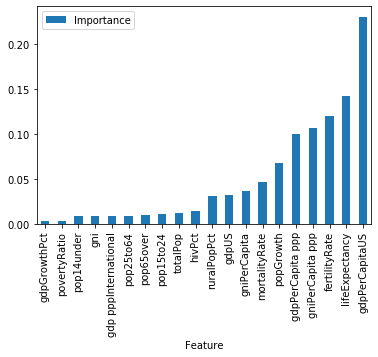

In [45]:
rf = RandomForestRegressor(max_features="sqrt")
# no need to scale for random forest

rf.fit(Xtrain, ytrain)
importances = rf.feature_importances_
print(len(importances))
print(len(Xtrain.columns))
importances = pd.DataFrame({'Feature':Xtrain.columns,'Importance':importances})
importances.sort_values(by='Importance').set_index('Feature').plot.bar()

These feature importance scores match my intuition.  It makes sense to me that GDP Per Capita PPP (Purchasing Power Parity) is the most important feature because it describes individual relative wealth.  It also makes sense that features like mortality rate, life expectancy, and fertility rate are more important than features like gdp and gdp growth.

In the cell below, I'm going to compare and contrast the model with all of the features to one with only the most important features.

In [10]:
errs = pd.Series()

all_cols = ['fertilityRate', 'lifeExpectancy', 'popGrowth',
           'ruralPopPct', 'mortalityRate', 'gdpGrowthPct', 
           'gdpUS', 'gdpPerCapita ppp', 'gdp pppInternational',
           'gni', 'gniPerCapita', 'happinessScore']

Xtrain_all = df_unesco_train[all_cols]
Xtrain_all = Xtrain_all.dropna()
ytrain_all = Xtrain_all["happinessScore"]
Xtrain_all.drop("happinessScore", axis=1, inplace=True)

best_cols = ['fertilityRate', 'lifeExpectancy', 'ruralPopPct', 'mortalityRate', 
             'gdpPerCapita ppp', 'gniPerCapita', 'happinessScore']

Xtrain_best = df_unesco_train[best_cols]
Xtrain_best = Xtrain_best.dropna()
ytrain_best = Xtrain_best["happinessScore"]
Xtrain_best.drop("happinessScore", axis=1, inplace=True)

def tryModel(Xtrain, ytrain):
    cv_errs = -cross_val_score(rf, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=10)
  
    return np.sqrt(cv_errs.mean())

iterations = 10
all_rmse = 0
best_rmse = 0

for i in range(iterations):
    all_rmse += tryModel(Xtrain_all, ytrain_all)
    best_rmse += tryModel(Xtrain_best, ytrain_best)
   
errs['All features'] = all_rmse/iterations
errs['Best features'] = best_rmse/iterations
errs

All features     0.599780
Best features    0.609655
dtype: float64

In [13]:
iterations = 10
errs = {}
for i in range(iterations):
    rmses = []
    rmses.append(tryModel(Xtrain_all, ytrain_all))
    rmses.append(tryModel(Xtrain_best, ytrain_best))
    errs[i] = rmses
   

errs = pd.DataFrame(errs)
errs = errs.rename({0: "All features", 1: "Best features"})
errs = errs.transpose()
errs

,All features,Best features
0,0.578558,0.589277
1,0.596980,0.595153
2,0.607864,0.604238
3,0.582882,0.626390
4,0.610274,0.596665
5,0.615611,0.634604
6,0.595253,0.600485
7,0.609468,0.614760
8,0.624111,0.616566
9,0.598786,0.629070


In [16]:
%%capture 
!pip install scikit-posthocs

In [18]:
import scikit_posthocs as sp

a = sp.posthoc_ttest(errs.transpose().values, p_adjust = 'bonferroni')
d = pd.DataFrame(a, columns=errs.columns,index=errs.columns)
display(d)
print(errs.mean().sort_values())

,All features,Best features
All features,-1.000000,0.210473
Best features,0.210473,-1.000000


All features     0.601979
Best features    0.610721
dtype: float64


In [63]:
# making graphs for a country over time, color coding by predicted vs known happiness data

#This method takes in country name and returns series of happiness score guesses from 1970 to 2017
# can be used to plot happiness score estimates vs year
Xtrain = df_combined[list(my_cols)]
Xtrain = Xtrain.dropna()
ytrain = Xtrain["happinessScore"]
Xtrain.drop("happinessScore", axis=1, inplace=True)

def predict_country(country):
    cols = my_cols
    cols.remove("happinessScore")
    Xtest = df_combined[list(cols)]
   
    df_country = df_unesco.loc[df_unesco['Country'] == country]
    df_country = df_country[list(my_cols)]
    df_country = df_country.reset_index()
    df_country = df_country.drop(['index'], axis=1)
    
#     df_new = df_unesco['Year'].unique()
#     print(len(df_new))
    y_pred = rf.fit(Xtrain, ytrain).predict(df_country)
    return pd.Series(y_pred)
    
    

happiness_predictions = predict_country("Iraq")


NameError: name 'df_combined' is not defined

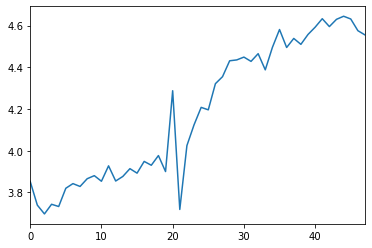

In [139]:
happiness_predictions.plot.line()


Predicted graph starting at 1970 to 2017 for Iraq
